In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
warnings.filterwarnings('ignore')

In [2]:
df_enrich = pd.read_csv('../data/enriched_nba_player_data.csv')
df_raw = pd.read_csv('../data/historic_nba_player_data.csv')
df_raw

,Season,Player,MP,PTS,AST,TRB,STL,BLK,TS%,PER,WS,BPM,VORP,USG%,W/L%,Share
0,2003,Tracy McGrady,39.4,32.1,5.5,6.5,1.7,0.8,0.564,30.3,16.1,10.5,9.3,35.2,0.512,0.359
1,2003,Kobe Bryant,41.5,30.0,5.9,6.9,2.2,0.8,0.550,26.2,14.9,7.1,7.7,32.9,0.610,0.417
2,2003,Allen Iverson,42.5,27.6,5.5,4.2,2.7,0.2,0.500,21.2,9.2,3.5,4.8,32.9,0.585,0.070
3,2003,Shaquille O'Neal,37.8,27.5,3.1,11.1,0.6,2.4,0.602,29.5,13.2,6.5,5.5,30.2,0.610,0.106
4,2003,Paul Pierce,39.2,25.9,4.4,7.3,1.8,0.8,0.532,22.7,10.1,4.9,5.4,33.2,0.537,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11338,2025,Riley Minix,7.0,0.0,0.0,2.0,0.0,0.0,0.000,-1.7,0.0,-11.8,0.0,6.1,0.415,0.000
11339,2025,Jahlil Okafor,3.0,0.0,1.0,1.0,0.0,0.0,0.000,13.8,0.0,7.5,0.0,0.0,0.610,0.000
11340,2025,Zyon Pullin,1.0,0.0,0.0,0.0,0.0,0.0,0.000,-11.7,0.0,-22.7,0.0,13.4,0.585,0.000
11341,2025,Isaiah Stevens,2.0,0.0,0.0,0.7,0.3,0.0,0.000,0.1,0.0,-11.8,0.0,14.8,0.451,0.000


In [3]:
train = df_enrich[df_enrich['Season'] < 2025].copy()
test = df_enrich[df_enrich['Season'] == 2025].copy()

In [4]:
X = train[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%', 'VORP_W/L']]

y = train['Share']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [7]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'auto']
}

grid = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

grid.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [10]:
rf_regr = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=20, max_features='sqrt',
                                     min_samples_leaf=2, min_samples_split=2, oob_score=True)

rf_regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, oob_score=True, random_state=42)

In [18]:
oob_score = rf_regr.oob_score_
print('Out-of-Bag Score:', oob_score)

yhat = rf_regr.predict(X_test)
base = np.zeros(len(yhat))

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
r2 = r2_score(y_test, yhat)
baseline = mean_absolute_error(y_test, base)

print('Mean Absolute Error:', mae)
print('Baseline', baseline)
print('Mean Squared Error:', mse)
print('r2 score:', r2)

Out-of-Bag Score: 0.7120313865065515
Mean Absolute Error: 0.0044188680575083595
Baseline 0.008024404086265606
Mean Squared Error: 0.00105342658628584
r2 score: 0.8068669467541973


In [20]:
df_val = train.copy()
df_val.loc[X_test.index, 'yhat'] = yhat

In [32]:
df_val = df_val.dropna().sort_values(by=['Share', 'yhat'], ascending=False)
df_val[['Season', 'Player', 'Share', 'yhat']].head(15)

,Season,Player,Share,yhat
3710,2013,LeBron James,0.998,0.908085
4099,2014,Kevin Durant,0.986,0.849299
5699,2018,James Harden,0.955,0.746437
6572,2020,Giannis Antetokounmpo,0.952,0.764451
8375,2024,Nikola Jokić,0.935,0.858653
7449,2022,Nikola Jokić,0.875,0.826152
777,2005,Steve Nash,0.839,0.077381
1497,2007,Steve Nash,0.785,0.235821
5295,2017,James Harden,0.746,0.566213
3301,2012,Kevin Durant,0.735,0.518435


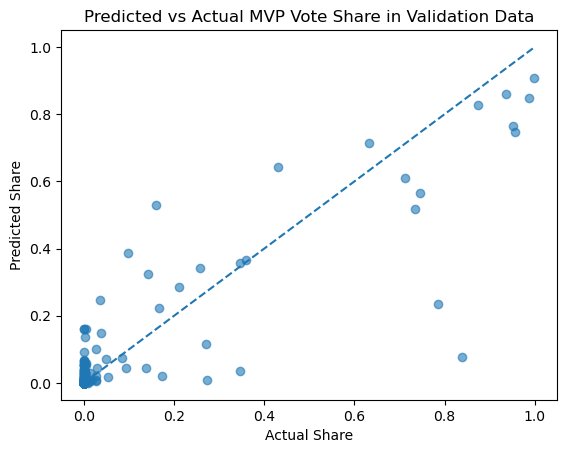

In [31]:
plt.scatter(y_test, yhat, alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Validation Data")
plt.show()

In [87]:
df_2025 = df_raw[df_raw['Season'] == 2025].copy()
X_2025 = df_2025[['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'W/L%']]
X_2025['VORP_W/L'] = X_2025['VORP'] * X_2025['W/L%']

scaled_columns = ['MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TS%', 'PER', 'WS', 'BPM', 'VORP', 'USG%', 'VORP_W/L']
scaler = StandardScaler()
scaler.fit(X_2025[scaled_columns])
X_2025[scaled_columns] = scaler.transform(X_2025[scaled_columns])

pred_2025 = df_2025.copy()
pred_2025['yhat_rf'] = rf_regr.predict(X_2025)
pred_2025[['Player', 'Share', 'yhat_rf']].sort_values(by=['yhat_rf', 'Share'], ascending=False).head(25)

,Player,Share,yhat_rf
10774,Shai Gilgeous-Alexander,0.913,0.746712
10776,Nikola Jokić,0.787,0.702022
10775,Giannis Antetokounmpo,0.470,0.405532
10779,Jayson Tatum,0.311,0.166529
11118,James Wiseman,0.000,0.138935
11156,Alondes Williams,0.000,0.128310
10778,Anthony Edwards,0.012,0.074876
10891,Jarrett Allen,0.000,0.057034
10835,Tyrese Haliburton,0.000,0.055268
10836,Evan Mobley,0.001,0.052609


In [88]:
base = np.zeros(len(pred_2025))

mae_test = mean_absolute_error(pred_2025['yhat_rf'], pred_2025['Share'])
mse_test = mean_squared_error(pred_2025['yhat_rf'], pred_2025['Share'])
baseline = mean_absolute_error(base, pred_2025['Share'])

print("Test MAE:", mae_test)
print("Test MSE:", mse_test)
print("Baseline MAE:", baseline)
print("R2 score:", r2_score(pred_2025['Share'], pred_2025['yhat_rf']))

Test MAE: 0.002443535919465827
Test MSE: 0.0002060196131648526
Baseline MAE: 0.004569420035149385
R2 score: 0.9335723953002634


In [89]:
rf_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_regr.feature_importances_})
rf_importances.sort_values(by='importance', ascending=False)

,feature,importance
13,VORP_W/L,0.264182
10,VORP,0.166087
7,PER,0.155031
8,WS,0.101275
9,BPM,0.091041
1,PTS,0.052666
11,USG%,0.037308
12,W/L%,0.035731
2,AST,0.018466
6,TS%,0.017966


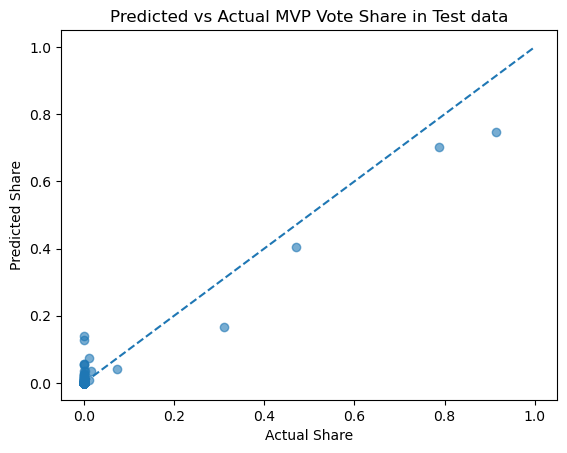

In [90]:
plt.scatter(pred_2025['Share'], pred_2025['yhat_rf'], alpha=0.6)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Test data")
plt.show()

Notes:
- The model outperforms the baseline, MAE of 0.0026 vs baseline of 0.0046
- The model performs well on unseen data with an r2 score of 0.92
- The model correctly predicts vote share between 0 and 1
- Some unexpected players still are predicted a higher vote share (James Wiseman, Alondes Williams)

In [47]:
pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 4.0 MB/s eta 0:00:18
   ---------------------------------------- 0.8/72.0 MB 2.0 MB/s eta 0:00:36
    --------------------------------------- 1.3/72.0 MB 2.5 MB/s eta 0:00:29
   - -------------------------------------- 1.8/72.0 MB 2.8 MB/s eta 0:00:26
   - -------------------------------------- 2.6/72.0 MB 2.7 MB/s eta 0:00:26
   - -------------------------------------- 2.9/72.0 MB 2.4 MB/s eta 0:00:29
   - -------------------------------------- 3.4/72.0 MB 2.5 MB/s eta 0:00:28
   -- ------------------------------------- 3.9/72.0 MB 2.4 MB/s eta 0:00:29
   -- ------------------------------------- 3.9/72.0 MB 2.4 MB/s eta 0:00:29
   -- ------------------------------------- 4.5/72.0 MB 2.3 MB/s eta 0:00:30
   -- ------------------------------------- 4.7/72.0 MB 2.1 MB/s eta 0:00:33
   -- ------------------------------------- 5.0/72.0 MB 2.0 MB/s eta 0:00:35
   --

In [57]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [91]:
params = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.3, 1],
    'reg_lambda': [0, 0.5, 1, 1.5]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

search = RandomizedSearchCV(
    xgb,
    param_distributions=params,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
-0.003904070162744745


In [92]:
xgb_regr = XGBRegressor(
    n_estimators=400,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=0,
    objective='reg:squarederror',
    random_state=42
)

xgb_regr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [93]:
yhat_xgb = np.clip(xgb_regr.predict(X_test), a_min=0, a_max=None)
base = np.zeros(len(yhat_xgb))

mae = mean_absolute_error(y_test, yhat_xgb)
mse = mean_squared_error(y_test, yhat_xgb)
r2 = r2_score(y_test, yhat_xgb)
baseline = mean_absolute_error(y_test, base)

print('Mean Absolute Error:', mae)
print('Baseline', baseline)
print('Mean Squared Error:', mse)
print('r2 score:', r2)

Mean Absolute Error: 0.004068222806419765
Baseline 0.008024404086265606
Mean Squared Error: 0.0009781553460899543
r2 score: 0.8206670203709886


In [94]:
df_val_xgb = train.copy()
df_val_xgb.loc[X_test.index, 'yhat'] = yhat_xgb

In [95]:
df_val_xgb = df_val_xgb.dropna().sort_values(by=['Share', 'yhat'], ascending=False)
df_val_xgb[['Season', 'Player', 'Share', 'yhat']].head(15)

,Season,Player,Share,yhat
3710,2013,LeBron James,0.998,0.901406
4099,2014,Kevin Durant,0.986,0.872912
5699,2018,James Harden,0.955,0.857121
6572,2020,Giannis Antetokounmpo,0.952,0.853590
8375,2024,Nikola Jokić,0.935,0.894331
7449,2022,Nikola Jokić,0.875,0.714244
777,2005,Steve Nash,0.839,0.136223
1497,2007,Steve Nash,0.785,0.220235
5295,2017,James Harden,0.746,0.727615
3301,2012,Kevin Durant,0.735,0.781828


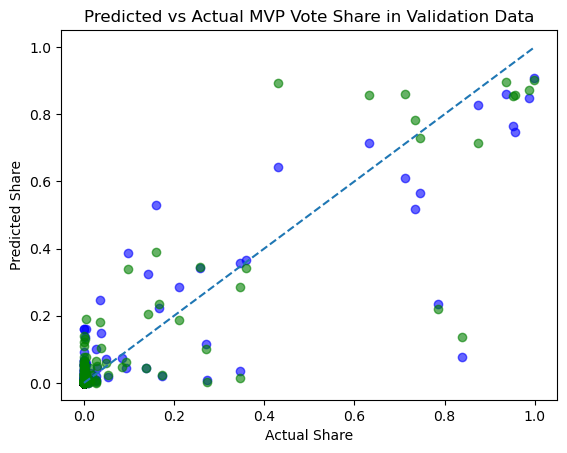

In [96]:
plt.scatter(y_test, yhat, alpha=0.6, color='b')
plt.scatter(y_test, yhat_xgb, alpha=0.6, color='g')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Validation Data")
plt.show() 

In [97]:
pred_2025['yhat_xgb'] = np.clip(xgb_regr.predict(X_2025), a_min=0, a_max=None)
pred_2025[['Player', 'Share', 'yhat_rf', 'yhat_xgb']].sort_values(by=['yhat_xgb'], ascending=False).head(25)

,Player,Share,yhat_rf,yhat_xgb
10774,Shai Gilgeous-Alexander,0.913,0.746712,0.735245
10776,Nikola Jokić,0.787,0.702022,0.611081
10775,Giannis Antetokounmpo,0.470,0.405532,0.401272
10779,Jayson Tatum,0.311,0.166529,0.113274
11118,James Wiseman,0.000,0.138935,0.050186
10836,Evan Mobley,0.001,0.052609,0.044001
10797,Donovan Mitchell,0.074,0.040720,0.042688
10879,Payton Pritchard,0.000,0.022532,0.042414
10891,Jarrett Allen,0.000,0.057034,0.041062
10829,Alperen Şengün,0.000,0.019803,0.037509


In [98]:
rf_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_regr.feature_importances_})
rf_importances.sort_values(by='importance', ascending=False)

,feature,importance
13,VORP_W/L,0.388553
10,VORP,0.245672
7,PER,0.072417
12,W/L%,0.048281
1,PTS,0.038345
11,USG%,0.035447
6,TS%,0.030317
3,TRB,0.024589
0,MP,0.023606
2,AST,0.023291


In [99]:
base = np.zeros(len(pred_2025))

xgb_test = mean_absolute_error(pred_2025['yhat_xgb'], pred_2025['Share'])
rf_test = mean_absolute_error(pred_2025['yhat_rf'], pred_2025['Share'])
baseline = mean_absolute_error(base, pred_2025['Share'])

print("XGBoost MAE:", xgb_test)
print("RandomForest MAE:", rf_test)
print("XGB r2 score:", r2_score(pred_2025['Share'], pred_2025['yhat_xgb']))
print("RF r2 score:", r2_score(pred_2025['Share'], pred_2025['yhat_rf']))

XGBoost MAE: 0.0020334058044158003
RandomForest MAE: 0.002443535919465827
XGB r2 score: 0.9321993929398193
RF r2 score: 0.9335723953002634


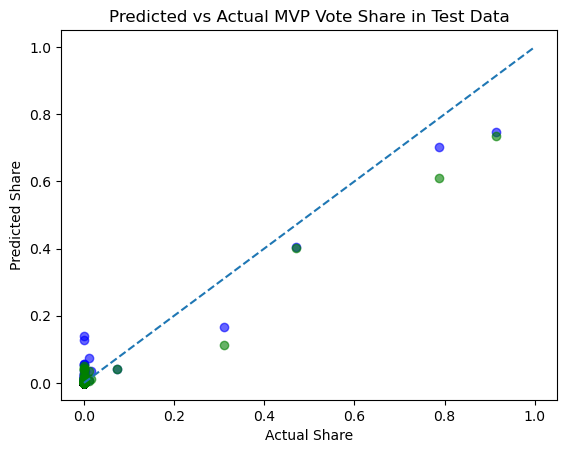

In [100]:
plt.scatter(pred_2025['Share'], pred_2025['yhat_rf'], alpha=0.6, color='b')
plt.scatter(pred_2025['Share'], pred_2025['yhat_xgb'], alpha=0.6, color='g')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Actual Share")
plt.ylabel("Predicted Share")
plt.title("Predicted vs Actual MVP Vote Share in Test Data")
plt.show()

Notes:
- XGBoost performs slightly better than an RF, MAE of 0.0018 vs 0.0026
- XGBoost does better on players with low vote share, with more clustered around 0,0
- Both models overpredict on outliers (James Wiseman low MP, high PER, BPM)